In [1]:
pip install pyston 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyston (from versions: none)
ERROR: No matching distribution found for pyston

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! conda install -c conda-forge fbprophet

'conda' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
import pandas as pd
import prophet
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality
from darts.metrics import r2_score, rmse
from darts.datasets import EnergyDataset
from darts.models.forecasting.prophet_model import Prophet


In [4]:
df = pd.read_csv('df_clean.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3480 non-null   object 
 1   price   3480 non-null   float64
dtypes: float64(1), object(1)
memory usage: 54.5+ KB


In [8]:
#changing into the date format
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')

In [9]:
#df.columns = ['ds', 'y']

In [10]:
#df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      8760 non-null   datetime64[ns]
 1   y       8760 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 205.3 KB


Train size :  2880
Test size  :  600



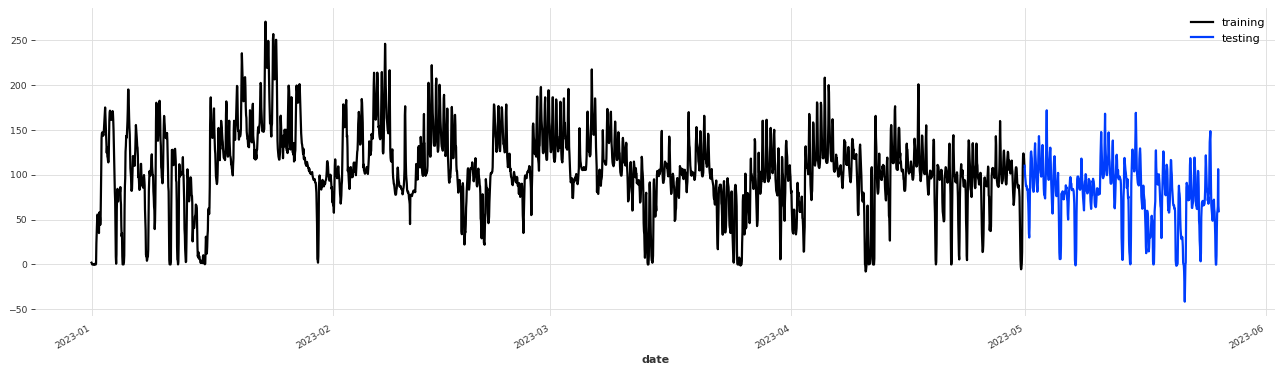

In [9]:
series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'price', fill_missing_dates=True, freq=None)

# dart recommendation, splitting dataset into train ad test
# no random split as the data is timeseries data
train, test = series.split_before(pd.Timestamp('05.01.2023 00:00'))
print("Train size : ", len(train))
print("Test size  : ", len(test))
print()

plt.figure(figsize=(20, 5), dpi=80)
train.plot(label="training")
test.plot(label="testing")
plt.show()

# Prophet Model building 

In [11]:
season=({'name': 'Price',
         'seasonal_periods': 24, #daily seasonility
         'fourier_order':1000})

In [12]:
model= Prophet(add_seasonalities = season)

In [13]:
model.fit(train)

14:01:59 - cmdstanpy - INFO - Chain [1] start processing
14:02:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities={'name': 'Price', 'seasonal_periods': 24, 'fourier_order': 1000}, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [14]:
pred_normal = model.predict(len(test))

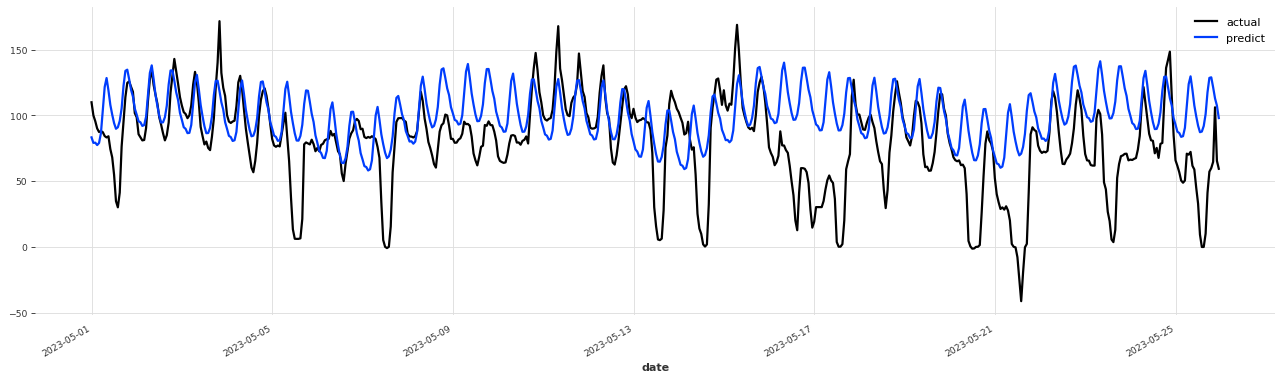

In [15]:
plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred_normal.plot(label="predict")
plt.show()

In [16]:
prophet_rmse_normal = rmse(test, pred_normal)
prophet_r2_normal   = r2_score(test, pred_normal)

In [17]:
print("RMSE : ", prophet_rmse_normal)
print("R2 score : ", prophet_r2_normal)

# this one is not god so trying historical forecast

RMSE :  37.24115475010109
R2 score :  -0.18689273973782794


In [18]:
series

<TimeSeries (DataArray) (date: 3480, component: 1, sample: 1)>
array([[[2.0100e+00]],

       [[1.3800e+00]],

       [[9.0000e-02]],

       ...,

       [[1.0608e+02]],

       [[6.5410e+01]],

       [[5.9320e+01]]])
Coordinates:
  * date       (date) datetime64[ns] 2023-01-01 ... 2023-05-25T23:00:00
  * component  (component) object 'price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [20]:
pred = model.historical_forecasts(series= series, forecast_horizon=24, 
                                         stride=24, 
                                         train_length=336, 
                                         start=pd.Timestamp('05.01.2023 00:00'), 
                                         verbose=False)

14:09:05 - cmdstanpy - INFO - Chain [1] start processing
14:09:07 - cmdstanpy - INFO - Chain [1] done processing
14:09:09 - cmdstanpy - INFO - Chain [1] start processing
14:09:10 - cmdstanpy - INFO - Chain [1] done processing
14:09:11 - cmdstanpy - INFO - Chain [1] start processing
14:09:12 - cmdstanpy - INFO - Chain [1] done processing
14:09:14 - cmdstanpy - INFO - Chain [1] start processing
14:09:14 - cmdstanpy - INFO - Chain [1] done processing
14:09:16 - cmdstanpy - INFO - Chain [1] start processing
14:09:17 - cmdstanpy - INFO - Chain [1] done processing
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing
14:09:21 - cmdstanpy - INFO - Chain [1] start processing
14:09:22 - cmdstanpy - INFO - Chain [1] done processing
14:09:24 - cmdstanpy - INFO - Chain [1] start processing
14:09:25 - cmdstanpy - INFO - Chain [1] done processing
14:09:26 - cmdstanpy - INFO - Chain [1] start processing
14:09:28 - cmdstanpy - INFO - Chain [1]

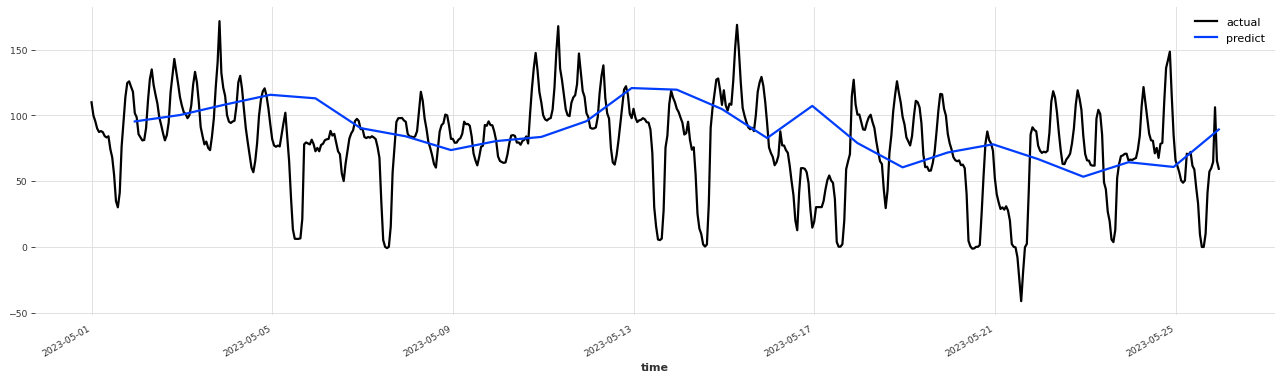

In [21]:
plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred.plot(label="predict")
plt.show()

In [22]:
# defining metrics for evaluation
prophet_rmse = rmse(test, pred)
prophet_r2   = r2_score(test, pred)

In [23]:
print("RMSE : ", prophet_rmse)
print("R2 score : ", prophet_r2)

RMSE :  26.43067318774029
R2 score :  -0.6171112441294775
